<a href="https://colab.research.google.com/github/chmo2019/EC523-Final-Project/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone repo
!git clone https://github.com/chmo2019/EC523-Final-Project

Cloning into 'EC523-Final-Project'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 175 (delta 95), reused 33 (delta 6), pack-reused 0
Receiving objects: 100% (175/175), 4.43 MiB | 3.37 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [2]:
# optional: pull changes
# !git pull

In [1]:
# navigate to source directory
%cd EC523-Final-Project/

/content/EC523-Final-Project


In [3]:
# fetch hdf5 dataset
!chmod +x fetch.sh
# !./fetch.sh

In [4]:
# fetch dataset if it doesn't already exist
import subprocess
import os

if not os.path.exists('./SEP28K.hdf5'):
  subprocess.run(["./fetch.sh"], shell=True)

In [5]:
# import necessary packages
from StutterNet import ResNet1D, train, StutterLoss, SEP28KDataset,sigmoid
import numpy as np
import torch
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, hamming_loss
import torchaudio as audio
from torch import nn
from torchvision.transforms import RandomApply

In [30]:
torch.backends.cudnn.benchmark = True

In [6]:
# read the hdf5 dataset
f = h5py.File("SEP28K.hdf5", 'r')

# create train, test, validation splits
trainX, trainY, testX, testY, validX, validY = f['trainX'], f['trainY'], f['testX'], f['testY'], f['validX'], f['validY']

# free up dataset
del f

In [33]:
# create required transforms
spec = audio.transforms.MelSpectrogram(n_mels=80, sample_rate=16000,
                                              n_fft=512, f_max=8000, f_min=0,
                                              power=0.5, hop_length=152, win_length=480)
db = audio.transforms.AmplitudeToDB()
transforms = torch.jit.script(nn.Sequential(spec, db))

In [18]:
# print transforms
print(transforms)

Sequential(
  (0): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (1): AmplitudeToDB()
)


In [34]:
# create torch dataset object(s)
train_ds = SEP28KDataset(trainX, trainY, transform=transforms)
test_ds = SEP28KDataset(testX, testY, transform=transforms)
valid_ds = SEP28KDataset(validX, validY, transform=transforms)

In [35]:
# print number of data points per split
print("size of train set: ", len(train_ds))
print("size of test set: ", len(test_ds))
print("size of val set: ", len(valid_ds))
print("total number of audio clips: ", len(train_ds) + len(test_ds) + len(valid_ds))

size of train set:  22537
size of test set:  2823
size of val set:  2817
total number of audio clips:  28177


/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()


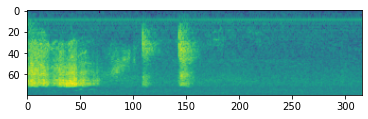

In [22]:
# visualize a mel spectrogram
import matplotlib.pyplot as plt
plt.imshow(train_ds[0][0])

In [12]:
# fetch class labels
names = np.loadtxt('classes.txt', dtype=str)

In [13]:
# convert labels to list
names = names.tolist()

In [27]:
# create torch data loaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valid_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [15]:
# get device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # get device

In [36]:
# initialize and train our network w/ CCC + Focal Loss and SGD
EPOCHS = 50
steps_per_epoch = len(train_ds) //  64
net = ResNet1D(80, kernel_size=21).to(device)
criterion = StutterLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=steps_per_epoch, 
                                                epochs=EPOCHS, div_factor=10000, cycle_momentum=False,
                                                pct_start=0.1, anneal_strategy='cos')
train(net, train_loader, criterion, 64, names, validationloader=val_loader, optimizer=optimizer, scheduler=scheduler, epochs=EPOCHS)


epoch 1/50


/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()


351/353 [============================>.] - ETA: 0s - loss: 0.9168

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWar

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.10      0.98      0.18       279
                Block       0.14      0.85      0.24       330
             SoundRep       0.08      1.00      0.15       228
              WordRep       0.12      0.86      0.21       274
         Interjection       0.21      1.00      0.35       583
     NoStutteredWords       0.65      0.60      0.62      1618

            micro avg       0.19      0.68      0.29      3770
            macro avg       0.11      0.44      0.15      3770
         weighted avg       0.35      0.68      0.38 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

 40/353 [==>...........................] - ETA: 40s - loss: 0.8704

KeyboardInterrupt: ignored

In [37]:
# prediction and groundtruth placeholders
preds = np.zeros((len(test_ds), 12))
gt = np.zeros((len(test_ds), 12))

# prediction counter
idx = 0

# set model to evaluation mode
net.eval()

# perform inference
for data in iter(test_loader):
  # get features and labels
  inputs, labels = data[0].to(device), data[1].detach().cpu().numpy()

  # get predictions
  outputs = net(inputs).detach().cpu().numpy()

  # get batch size
  batch_size = outputs.shape[0]
  
  # store predictions and labels
  preds[idx:idx+batch_size, :] = outputs
  gt[idx:idx+batch_size, :] = labels

  # increment counter
  idx += batch_size

# print metrics
preds = (sigmoid(preds) > 0.5).astype('int')
gt = gt.astype('int')
print(classification_report(gt, preds, target_names=names, zero_division=1))
print("Multilabel Accuracy: {:.2f}".format(1-hamming_loss(gt, preds)))

/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()


                       precision    recall  f1-score   support

     PoorAudioQuality       1.00      0.00      0.00        59
               Unsure       1.00      0.00      0.00         3
DifficultToUnderstand       1.00      0.00      0.00        99
         NaturalPause       1.00      0.00      0.00       240
                Music       1.00      0.00      0.00        31
             NoSpeech       1.00      0.00      0.00        29
         Prolongation       0.20      0.52      0.29       264
                Block       0.13      0.79      0.23       336
             SoundRep       0.08      1.00      0.15       225
              WordRep       0.10      1.00      0.19       289
         Interjection       0.34      0.72      0.46       597
     NoStutteredWords       0.60      0.91      0.72      1616

            micro avg       0.23      0.75      0.36      3788
            macro avg       0.62      0.41      0.17      3788
         weighted avg       0.47      0.75      0.44 